# Introduction

Currently, the MLB uses human umpires to determine ball/strike calls at home plate for each pitch in a baseball game. While it has been the standard since the sport's inception, there are some that believe an update is needed to the game that automates this process, primarily for the purpose of accuracy. A machine with sensors (photogrammetry, videography, radar, lidar) can much better detect the exact location of a baseball as it crosses home plate than the human eye can, regardless of hours of training a person to perform this action.

Independent of whether this notion of "upgrading the game" is correct or not, it poses an interesting machine learning problem: Can a model accurately create the strikezone for each player that comes to the plate?

The answer is "yes", but how would it be performed? This script will take information from the MLB statcast for each pitch in a particular time period, and for each particular player up to bat. From there it will attempt to categorize balls and strikes based on each player.

The biggest limitation to the data for this model will undoubtedly be the "ball/strike" as called by the umpire. Since we have no other way (at the moment) to create a better strike zone from scratch, we can only use the one established by each umpire. This comes with human error, since sometimes the umpires get it wrong (hence the desire for this model in the first place). An assumption will be made in the beginning that these erreneous calls can be considered "outliers" and will not affect the models ability to generalize. However, if it becomes too much of a factor, we will need to perform some data cleaning in order to remedy the situation.

## Imports

Packages that will be necessary for this analysis. They will be installed in our virtaul environment first via `pip`, then imported. Luckily for us, somebody has already made a python scraper for the data we are looking for. We can utilize that here to make obtaining the data a bit easier.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import plotly.graph_objects as go

#import matplotlib so that we can use dark background for seaborn
from matplotlib import pyplot as plt
plt.style.use('dark_background')

# import our necessary tensorflow packages
import tensorflow as tf
from tensorflow.keras import layers

#MLB Scraper grabs from MLB statcast and savant
from pybaseball import statcast

2022-08-04 13:12:21.593361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 13:12:21.593379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Extraction

Lets grab some pitch data from the statcast just to see what we are working with

In [2]:
# Nothing special about these dates
start = '2022-05-01'
finish = '2022-05-02'

df = statcast(start_dt=start, end_dt=finish)
df.head()

This is a large query, it may take a moment to complete


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1544,FS,2022-05-02,97.6,-1.97,6.29,"Duran, Jhoan",663527,661395,strikeout,swinging_strike,...,2,2,1,1,2,Standard,Standard,221,-0.044,-0.06
1629,CU,2022-05-02,87.9,-1.98,6.3,"Duran, Jhoan",663527,661395,NaN,foul,...,2,2,1,1,2,Standard,Standard,57,0.0,0.0
1644,FS,2022-05-02,97.3,-2.15,6.3,"Duran, Jhoan",663527,661395,NaN,called_strike,...,2,2,1,1,2,Standard,Standard,218,0.0,-0.023
1707,FS,2022-05-02,96.9,-2.27,6.16,"Duran, Jhoan",663527,661395,NaN,swinging_strike,...,2,2,1,1,2,Standard,Standard,223,0.0,-0.018
1809,FS,2022-05-02,97.8,-2.17,6.27,"Duran, Jhoan",663624,661395,field_out,hit_into_play,...,2,2,1,1,2,Standard,Standard,225,-0.064,-0.161


Alright, so it looks like we have 92 unique features in this dataset. While we can look at pitch metrics momentarily, the first issue I see is the columns "batter" and "pitcher". It looks like they are associated with numbers, and I am unsure who those numbers are meant to represent. The documentation on mlb savant, or the python package, may be able to help us track down that information.

Because I still have the github open, it looks like the number for batter and pitcher is defined as "MLBAM ID". Not entirely sure what that is at the moment, but one piece of information we can immediately discern is that "player_name" feature refers to the pitcher, just by looking at the first 5 datapoints. Notice that the batter number changes after 3 strikes called (count strikes in the "description" column). However, the pitcher number does not, so that's some useful info. Still, we need some `key:value` pairs to associate batter # with who they actually are.

Doing some digging, a website `smartfantasybaseball.com` contains a list of mlb player id's to their names. Luckily, it comes with a .csv file, so we can add that to our dataframe to better understand the players up to bat. However, this is not required initially, because our model does not necessarily need to know their names. It simply helps us understand the person we are modeling. Therefore, we will save this step for last.

# Data Cleaning

So, after looking at the columns in the dataframe and the rows in the dataframe, it is already becoming clear that the order that the rows got entered into the dataframe is a bit odd. The index of the data does not match the index of the dataframe. However, this is not really a problem, because I intend to organize the data by batter ID for now (and eventually change this to batter name).

In [3]:
data = df.set_index(['batter'])
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
batter,,,,,,,,,,,,,,,,,,,,,
663527,FS,2022-05-02,97.6,-1.97,6.29,"Duran, Jhoan",661395,strikeout,swinging_strike,<NA>,...,2,2,1,1,2,Standard,Standard,221,-0.044,-0.06
663527,CU,2022-05-02,87.9,-1.98,6.3,"Duran, Jhoan",661395,NaN,foul,<NA>,...,2,2,1,1,2,Standard,Standard,57,0.0,0.0
663527,FS,2022-05-02,97.3,-2.15,6.3,"Duran, Jhoan",661395,NaN,called_strike,<NA>,...,2,2,1,1,2,Standard,Standard,218,0.0,-0.023
663527,FS,2022-05-02,96.9,-2.27,6.16,"Duran, Jhoan",661395,NaN,swinging_strike,<NA>,...,2,2,1,1,2,Standard,Standard,223,0.0,-0.018
663624,FS,2022-05-02,97.8,-2.17,6.27,"Duran, Jhoan",661395,field_out,hit_into_play,<NA>,...,2,2,1,1,2,Standard,Standard,225,-0.064,-0.161


In [4]:
data
data.iloc[0]

pitch_type                                FS
game_date                2022-05-02 00:00:00
release_speed                           97.6
release_pos_x                          -1.97
release_pos_z                           6.29
                                ...         
if_fielding_alignment               Standard
of_fielding_alignment               Standard
spin_axis                                221
delta_home_win_exp                    -0.044
delta_run_exp                          -0.06
Name: 663527, Length: 91, dtype: object

Great, so it looks like our reindexing is successful, and aligns how we would expect with `pandas.iloc[]`. 

## Ball/Strikes Only

For this model, we are only interested in snippets of the data where there was a called strike or ball by the umpire. We will certainly explore more of this data in the future, but this will be first. We also want to get rid of any events where the batter swung at a pitch, since this could have unintended consequences for the data (what if the player swung at a ball? We would classify it as a strike, but it could be well outside the strike zone).

Lets take a look at what categories are offered by the `description` column of the dataframe

In [5]:
data['description'].unique()

array(['swinging_strike', 'foul', 'called_strike', 'hit_into_play',
       'ball', 'blocked_ball', 'foul_tip', 'foul_bunt',
       'swinging_strike_blocked', 'hit_by_pitch'], dtype=object)

Perfect, so it looks like we want to filter down our data by `called_strike`, 'blocked_ball', and `ball` (blocked ball being a ball that the catcher stopped from going into the backstop). This should give us the data we would want to feed into the model.

In [6]:
filter = data[(data['description'] == 'called_strike') |
               (data['description'] == 'blocked_ball') |
               (data['description'] == 'ball')]

filter.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitcher,events,description,spin_dir,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
batter,,,,,,,,,,,,,,,,,,,,,
663527,FS,2022-05-02,97.3,-2.15,6.3,"Duran, Jhoan",661395,NaN,called_strike,<NA>,...,2,2,1,1,2,Standard,Standard,218,0.0,-0.023
623993,CU,2022-05-02,88.2,-2.0,6.41,"Duran, Jhoan",661395,NaN,ball,<NA>,...,2,2,1,1,2,Infield shift,Standard,45,0.0,0.016
623993,FF,2022-05-02,99.5,-2.13,6.42,"Duran, Jhoan",661395,NaN,called_strike,<NA>,...,2,2,1,1,2,Strategic,Strategic,222,0.0,-0.034
669304,SL,2022-05-02,83.1,2.51,5.19,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Standard,Standard,310,0.0,0.016
596146,FF,2022-05-02,91.0,2.45,5.2,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Infield shift,Standard,135,0.0,0.031
596146,SL,2022-05-02,84.4,2.56,5.17,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Strategic,Standard,299,0.0,0.023
593871,SL,2022-05-02,83.9,2.51,5.17,"Fry, Paul",643316,NaN,called_strike,<NA>,...,1,2,1,2,1,Standard,Standard,335,0.0,-0.055
593871,FF,2022-05-02,91.7,2.43,5.26,"Fry, Paul",643316,NaN,ball,<NA>,...,1,2,1,2,1,Standard,Standard,135,0.0,0.025
593871,SL,2022-05-02,83.0,2.47,5.23,"Fry, Paul",643316,NaN,called_strike,<NA>,...,1,2,1,2,1,Standard,Standard,308,0.0,-0.034


Success, we filtered down the data a bit. These ball / strike calls will be used for our labels going into Tensorflow and Scikit-learn (after we "one-hot" them). Now, we need to get our desired features in order.

Suppose we are already planning on performing the model on each batter, such that the strike zone will be unique to each batter (and we can even eventually get a 'global' strikezone). If this is the case, what features do we use to determine the zone? The obvious answer is distance from certain x,y coordinates from the plate. 

Looking at the documentation from baseball savant, it looks like we can use the following:
1. `plate_x`: Horizontal position of the ball when it crosses home plate from the catcher's perspective.
2. `plate_z`: Vertical position of the ball when it crosses home plate from the catcher's perspective.

Pretty much exactly what we are looking for. Now we can determine a relationship between each ball/strike call, and the position of the ball when it crosses the plate. Lets make some plots for all batters and see what comes up!


/home/mattgpaul/Documents/Python Projects/AutoStrikeZone/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


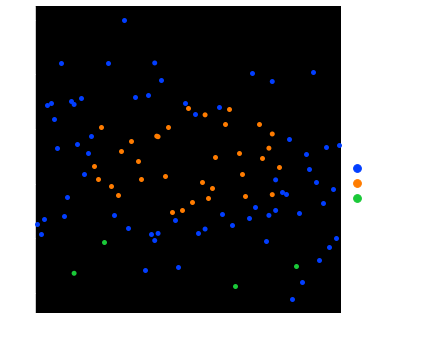

In [7]:
catplot = sns.catplot(x='plate_x', 
                      y='plate_z', 
                      hue='description', 
                      kind='swarm', 
                      data=filter.sample(100),
                      palette=sns.color_palette('bright'))
for index, label in enumerate(catplot.ax.get_xticklabels()):
    if index % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)


Well well well. Just looking at the plots and we can see some obvious categorical areas from the spread of the data. Furthermore, it is pretty obvious that we should also simply classify `blocked_ball` as a `ball` when we eventually remap the dataframe with a one-hot. We could also benefit from normalizing the features. Not strictly necessary here, but we will do it anyway.

OK, so lucky us. Not too much data cleaning, features are playing nice, a clear correlation appears to be present, lets get the data finalized for our learning model.

Seeing as how the results of the model will change for each individual batter, it would likely be much better to get a bunch of data from one batter to start. We have seen how the data comes in, and what we need to alter. We can probably just make a function to handle the data cleaning from here on out, with the batter ID as an input for obtaining the data.

In [8]:
# Looks like the player_id mapping is already done for us in the github
from pybaseball import playerid_lookup
from pybaseball import statcast_batter

In [9]:
def batterBallStrikeData(batter_last_name, batter_first_name, start_date, end_date):

    # Call the python baseball scraper for the batter desired, rather than all batters for all timeframes
    # This way, we do not load too much data into memory at once
    print(batter_last_name, batter_first_name)
    batter_id = playerid_lookup(batter_last_name, batter_first_name)['key_mlbam'].values[0]
    batter_stats = statcast_batter(start_dt=start_date, end_dt=end_date, player_id=batter_id)
    
    batter_stats = batter_stats[(batter_stats['description'] == 'called_strike') |
                                (batter_stats['description'] == 'blocked_ball') |
                                (batter_stats['description'] == 'ball')]

    return batter_stats, batter_id

Trout Mike
Gathering player lookup table. This may take a moment.
Gathering Player Data


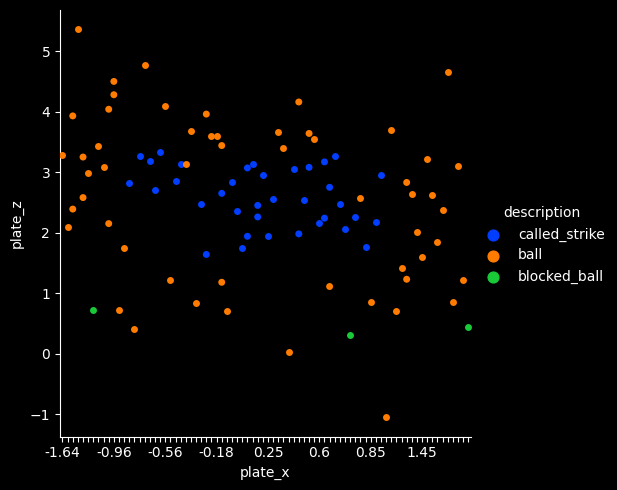

In [10]:
df, id = batterBallStrikeData('Trout','Mike','2020-01-01','2022-01-01')
catplot = sns.catplot(x='plate_x', 
                      y='plate_z', 
                      hue='description', 
                      kind='swarm', 
                      data=df.sample(100),
                      palette=sns.color_palette('bright'))
for index, label in enumerate(catplot.ax.get_xticklabels()):
    if index % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

Lets also get the `sns.plairplot` for giggles

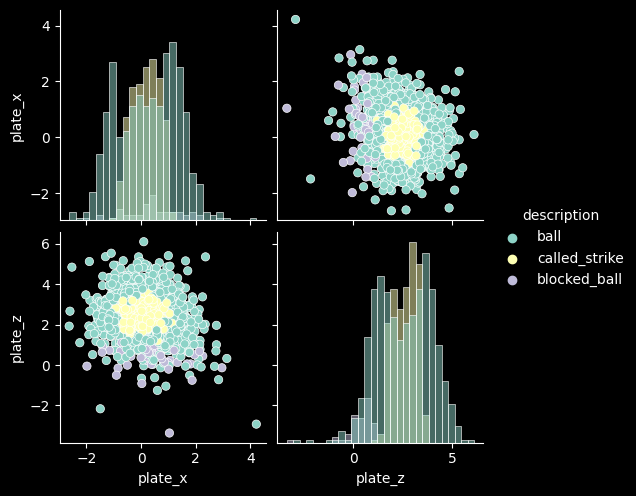

In [11]:
sns.pairplot(df[['plate_x','plate_z','description']], hue='description', diag_kind='hist')

Darn, still some nans in there. Lets do that final bit of cleanup before we get into the model. We also need to change the description of "blocked ball" to just "ball", since for the purposes of this model, they can be treated exactly the same.

In [12]:
# Only run this once. It will break the code if run twice
mapper = {'blocked_ball':'ball','called_strike':'strike','ball':'ball'}
df['description'] = df['description'].map(mapper)

In [13]:
df.dropna(axis=0, how='any', subset=['description','plate_x','plate_z'], inplace=True)
df


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2021-05-17,95.1,1.85,6.60,"Trout, Mike",545361,656529,walk,ball,...,1,1,0,0,1,Standard,Standard,136.0,0.022,0.187
1,FF,2021-05-17,93.6,1.58,6.66,"Trout, Mike",545361,656529,NaN,ball,...,1,1,0,0,1,Standard,Standard,146.0,0.016,0.137
2,CU,2021-05-17,80.2,1.64,6.77,"Trout, Mike",545361,656529,NaN,strike,...,1,1,0,0,1,Standard,Standard,321.0,0.000,-0.061
3,CU,2021-05-17,79.7,1.70,6.64,"Trout, Mike",545361,656529,NaN,ball,...,1,1,0,0,1,Standard,Standard,321.0,0.000,0.070
4,FF,2021-05-17,94.6,1.79,6.66,"Trout, Mike",545361,656529,NaN,ball,...,1,1,0,0,1,Standard,Standard,144.0,0.000,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,FF,2020-07-20,94.3,-2.21,5.98,"Trout, Mike",545361,572070,NaN,ball,...,0,0,0,0,0,Standard,Standard,198.0,0.000,NaN
1804,FF,2020-07-20,94.1,2.31,6.33,"Trout, Mike",545361,519141,NaN,ball,...,0,1,0,1,0,Standard,Strategic,159.0,0.000,NaN
1805,FF,2020-07-20,94.2,2.58,6.30,"Trout, Mike",545361,519141,NaN,ball,...,0,1,0,1,0,Standard,Strategic,158.0,0.000,NaN
1807,FF,2020-07-20,93.4,2.52,6.22,"Trout, Mike",545361,519141,NaN,strike,...,0,1,0,1,0,Standard,Standard,154.0,0.000,NaN



## Pre-processing

So first step here is to get our labels into a "one-hot" formation. We will save the mapper here as well so that we can interpret the results later.

In [14]:
onehot_map = {key:value for value, key in enumerate(df['description'].unique())}
labels_mapped = df['description'].map(onehot_map)
labels_mapped

0       0
1       0
2       1
3       0
4       0
       ..
1803    0
1804    0
1805    0
1807    1
1808    1
Name: description, Length: 1070, dtype: int64

# Scikit-Learn
## Naive Bayes Classification

Lets start with a simple classifier and see if it can perform the outcome desired for ball-strike calls. We may get more sophisticated if it is necessary. Also, lets try using the dataset before and after normalization and one-hot mapping to see if it makes a difference. Who knows, simplicity might be the best medicine for the data.


In [15]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Train and test splitting using our original df (tensor) after dropping nans and renaming blocked balls
Xtrain, Xtest, ytrain, ytest = train_test_split(df, labels_mapped, random_state=1)

With all the data separated, lets try our first simple model

In [16]:
# Make sure model is cleared
features = ['plate_x','plate_z']
model = GaussianNB()
model.fit(Xtrain[features], ytrain)
y_model = model.predict(Xtest[features])


In [17]:
accuracy_score(ytest, y_model)

0.8955223880597015

Hmmm, about 90% accurate. Seems pretty good. There are some other things I want to look at to evaluate this score. For example, I can imagine that the decision boundary for the model is going to have lots of "curves" to the plot. In the rule book, it would be established as a rectangle, but I doubt the model would represent that, since it is working on the basis of the calls made by umpires, not the rulebook. Lets take a look.

In [18]:
import importlib
import utils
importlib.reload(utils)

fig = utils.PlotDecisionBoundary(model, Xtrain[features], ytrain, label_map = onehot_map.keys())
fig.show()

## Model Predictions

So, what does this data tell us? Honestly, not a whole lot. Our lack of an ability (at the moment) to compare this to a "rulebook" strikezone means that what we have here is __*a model that predicts Mike Trout's strike zone, as determined by the umpires, for all pitches not swung at, between the start and end date established, with ~90\% accuracy.*__

However, with some assumptions made about the model, we can make some inferences. For instance, with enough data for each player, we can establish their "as-called" strike zone. Given a well generalized model, this could be enough to estalish a strike-zone that is *close enough* to the rulebook strike-zone such that we have confidence in our ability to predict balls and strikes for each player. 

Regardless of what we can do to improve the model or attempt to compare to the rulebook strike zone (more on these in later versions), for now, we can attampt to have some fun with the model we have established. For instance, we have a model that predicts balls and strikes for Mike Trout's strike-zone. It would be interesting to know the following:
-  Which pitch type(s) caused the most false positives/negatives
-  What pitching zones caused the most false positives/negatives
-  Any pitchers get bonuses/rejections when facing Mike Trout
-  Any other interesting metrics

Lets start with the first on that list and identify if any particular pitch caused false positives/negatives. Based on some critical thinking, my initial guess is going to be offspeed pitches (curveball, slider, etc.). Anything meant to fool the batter would likely have the unintended effect of fooling the umpire right?

In [19]:
# Get the predictions for the model based on the training data
ytrain_model = model.predict(Xtrain[features])

# Get false positives/negatives from the model
wrong = ytrain[ytrain != ytrain_model].index

# Grab these indices from the dataset and show them on the plot
Xmissed = Xtrain.loc[wrong]
fig.add_trace(go.Scatter(
    x=Xmissed['plate_x'],
    y=Xmissed['plate_z'],
    mode='markers',
    name='missed_calls',
    marker_color='red'
))


Again, just so it is clear, these missed calls are under the assumption that OUR MODEL IS CORRECT, and that any call made outside the confines of this model would be considered an error by the umpire. Unsuprisingly, missed calls surround the edges of the strike zone. But what were these pitches when the call was made?

In [20]:
# Grab the missed calls from our original dataframe
df_missed = df.loc[wrong]
df_missed['pitch_type']

1634    FC
833     SL
813     SI
173     FF
1459    FC
        ..
939     CH
796     SI
349     FF
542     FF
206     SL
Name: pitch_type, Length: 97, dtype: object

Some of those abbreviations are clear, some aren't. Lets establish another map and add it to the df

In [25]:
# Pitch name dictionary to its abbreviation
pitch_dict = {
    'CH':'Changeup',
    'CU':'Curveball',
    'FC':'Cutter',
    'EP':'Eephus',
    'FO':'Forkball',
    'FF':'Four-Seam Fastball',
    'KN':'Knuckleball',
    'KC':'Knuckle-curve',
    'SC':'Screwball',
    'SI':'Sinker',
    'SL':'Slider',
    'FS':'Splitter',
    'FT':'Two-Seam Fastball',
    'CS':'Caught Stealing'
}
# Create a new column with the dictionary mapping
df['pitch_name'] = df['pitch_type'].map(pitch_dict).astype(str)

# One of these appears to be "Caught Stealing"? 
# This would not cross the plate, so lets drop that data point (there is only 1, I checked)
df = df.drop(df[df['pitch_type'] == 'CS'].index)
df['pitch_name']

0       Four-Seam Fastball
1       Four-Seam Fastball
2                Curveball
3                Curveball
4       Four-Seam Fastball
               ...        
1803    Four-Seam Fastball
1804    Four-Seam Fastball
1805    Four-Seam Fastball
1807    Four-Seam Fastball
1808         Knuckle-curve
Name: pitch_name, Length: 1069, dtype: object

Now lets plot the labels on missed calls, just to see before we start getting probabilities

In [31]:
df['pitch_name'] = df['pitch_name']

# reinstate df_missed so that it has our pitch names
df_missed = df.loc[wrong]

# Plot the new traces
plots = []
for pitch in df_missed['pitch_name'].unique():
    dfplot = df_missed[df_missed['pitch_name'] == pitch]
    plots.append(go.Scatter(
        x=dfplot['plate_x'],
        y=dfplot['plate_z'],
        mode='markers',
        name=pitch,
    ))
fig.add_traces(data=plots)

Interesting, so it appears that for Mike Trout, the most likely pitch to be erreneously called against him is a Four-Seam Fastball. Perhaps because this is likely the fastest pitch, and that the umpire may not have the reaction time to adequately classify the pitch?

Regardless of the reasons, we can calculate the probability that each pitch will be called incorrectly by doing some quick math.

In [39]:
pitch_prob = {key:len(df_missed[df_missed['pitch_name'] == key])/len(df_missed)*100 for key in df_missed['pitch_name'].unique()}
pitch_prob

{'Cutter': 6.185567010309279,
 'Slider': 13.402061855670103,
 'Sinker': 21.649484536082475,
 'Four-Seam Fastball': 45.36082474226804,
 'Changeup': 5.154639175257731,
 'Curveball': 8.24742268041237}

And that makes sense. So from this dataset and model, for all missed calls against Mike Trout, the Four-Seam has a 45\% chance of being miscalled.

# Different Models and Players

Up until now, we have only looked at Mike Trout, and using a Naive Bayes Classification algorithm. It wouldn't be data science if we didn't look at more information, so lets perform the following:
-  Load data for a list of players across multiple team rosters, and determine their strike zones
-  Do this for multiple regression models

Because I have laid the groundwork for the model with Mike trout, I will not go too in depth for explanations until we start working with new models.

In [57]:
# Redefine our player data function to incorporate necessary cleaning we did previously
def GetBatterData(batter_last_name, batter_first_name, start_date, end_date):
    print(batter_last_name, batter_first_name)
    batter_id = playerid_lookup(batter_last_name, batter_first_name)['key_mlbam'].values[0]
    batter_stats = statcast_batter(start_dt=start_date, end_dt=end_date, player_id=batter_id)
    batter_stats['batter_name'] = batter_first_name + ' ' + batter_last_name

    mapper = {'blocked_ball':'ball','called_strike':'strike','ball':'ball'}
    batter_stats['description'] = batter_stats['description'].map(mapper)
    batter_stats.dropna(axis=0, how='any', subset=['description','plate_x','plate_z'], inplace=True)

    pitch_dict = {
    'CH':'Changeup',
    'CU':'Curveball',
    'FC':'Cutter',
    'EP':'Eephus',
    'FO':'Forkball',
    'FF':'Four-Seam Fastball',
    'KN':'Knuckleball',
    'KC':'Knuckle-curve',
    'SC':'Screwball',
    'SI':'Sinker',
    'SL':'Slider',
    'FS':'Splitter',
    'FT':'Two-Seam Fastball',
    'CS':'Caught Stealing'
    }

    batter_stats['pitch_name'] = batter_stats['pitch_type'].map(pitch_dict).astype(str)
    batter_stats = batter_stats.drop(batter_stats[batter_stats['pitch_type'] == 'CS'].index)
    batter_stats.reset_index(drop=True, inplace=True)

    return batter_stats


In [66]:
# Players to look into
players = {
    'name':[('Trout', 'Mike'),('Judge', 'Aaron'),('Crawford', 'Brandon'),('Altuve', 'Jose')],
}

# Lets look back for until 2017
start_dt = '2017-01-01'
end_dt = '2022-08-03'

# Loop through players and store in a dataframe
df = pd.DataFrame()
for player in players['name']:
    playerdf = GetBatterData(player[0], player[1], start_dt, end_dt)
    df = pd.concat([df, playerdf])




Trout Mike
Gathering Player Data
Judge Aaron
Gathering Player Data
Crawford Brandon
Gathering Player Data
Altuve Jose
Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
batter_name,,,,,,,,,,,,,,,,,,,,,
Mike Trout,FF,2022-07-12,92.1,-2.22,6.26,"Trout, Mike",545361,677651,NaN,strike,...,3,3,1,1,3,Infield shift,Standard,200.0,0.0,-0.042
Mike Trout,SL,2022-07-12,78.9,-2.26,6.24,"Trout, Mike",545361,677651,NaN,ball,...,3,3,1,1,3,Infield shift,Standard,46.0,0.0,0.033
Mike Trout,FC,2022-07-12,85.3,-2.23,6.26,"Trout, Mike",545361,677651,NaN,ball,...,2,2,0,0,2,Infield shift,Standard,167.0,0.0,0.053
Mike Trout,FC,2022-07-10,89.6,-2.76,5.92,"Trout, Mike",545361,608723,NaN,ball,...,0,2,0,2,0,Infield shift,Standard,181.0,0.0,0.024
Mike Trout,FF,2022-07-10,92.5,-2.61,6.03,"Trout, Mike",545361,608723,NaN,ball,...,0,2,0,2,0,Infield shift,Standard,211.0,0.0,0.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jose Altuve,FF,2017-03-31,87.5,-1.95,6.17,"Altuve, Jose",514888,543294,NaN,strike,...,0,0,0,0,0,Standard,Standard,186.0,0.0,NaN
Jose Altuve,FF,2017-03-31,87.9,-1.92,6.20,"Altuve, Jose",514888,543294,NaN,strike,...,0,0,0,0,0,Standard,Standard,202.0,0.0,NaN
Jose Altuve,CH,2017-03-31,79.3,-1.86,6.24,"Altuve, Jose",514888,543294,NaN,ball,...,0,0,0,0,0,Standard,Standard,209.0,0.0,NaN


In [ ]:
df.set_index('batter_name',inplace=True)
df